In [1]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [3]:
model_name = 'ViT-B-32-quickgelu'
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained='laion400m_e32', device=device)
tokenizer = open_clip.get_tokenizer(model_name)
cifar_test = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = preprocess, download=True)

Files already downloaded and verified


In [7]:
cifar_test.classes = [x.replace('_',' ') for x in cifar_test.classes]

In [58]:
text = tokenizer(cifar_test.classes)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text.to(device))
    text_features /= text_features.norm(dim=-1, keepdim=True)
dataloader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False)
predictions = np.array([])
actual = np.array([])
probs = np.array([])
order = np.array([])
all_probs = None
for image, labels in tqdm(dataloader, total=len(cifar_test) // batch_size):
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image.to(device))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        #if temp_scaling is not None:
        #    image_features = torch.div(image_features, temp_scaling)
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    if all_probs is None:
        all_probs = text_probs.cpu().numpy()
    else:
        all_probs = np.concatenate((all_probs, text_probs.cpu().numpy()))
    vals, indics = text_probs.max(dim=1)
    predictions = np.append(predictions, indics.cpu().numpy())
    for i,l in enumerate(labels):
        order = np.append(order, (torch.where(torch.argsort(text_probs,dim=1, descending=True)[i] == l)[0].item()))
    actual = np.append(actual, labels.numpy())
    probs = np.append(probs, vals.cpu().numpy())

79it [00:23,  3.33it/s]                        


Text(0.5, 1.0, 'Order of Wrongly predicted samples of CLIP on CIFAR100')

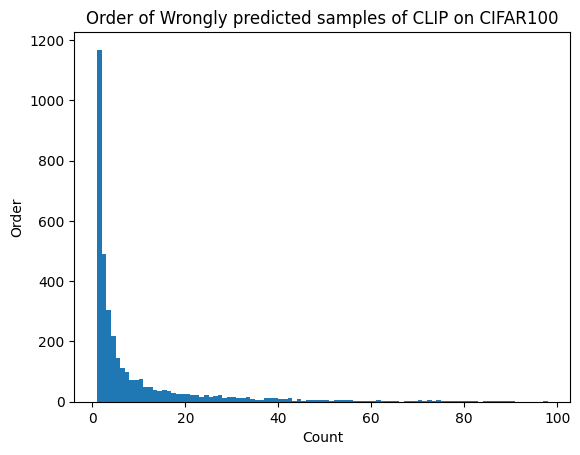

In [80]:
plt.hist(order[order > 0], bins=np.arange(1, max(order), 1))
plt.ylabel('Order')
plt.xlabel('Count')
plt.title('Order of Wrongly predicted samples of CLIP on CIFAR100')

In [84]:
np.where(order > 80)[0]

array([1783, 3151, 3644, 3760, 4706, 5619, 5896, 6080, 6885, 8150, 8381,
       9508, 9686, 9769])

In [85]:
vis = datasets.CIFAR100('/home/ubuntu/data/', train = False, transform = None, download=True)

Files already downloaded and verified


Text(0.5, 1.0, 'fox , squirrel')

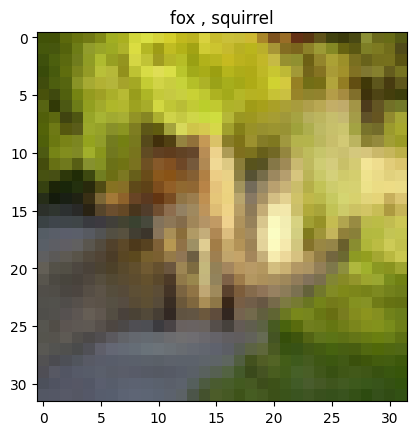

In [95]:
a = 4706
plt.imshow(vis[a][0])
plt.title(vis.classes[vis[a][1]] + ' , ' + vis.classes[int(predictions[a])])